In [2]:
import numpy as np
import networkx as nx
import numpy.linalg as la
import scipy.cluster.vq as vq
import matplotlib.pyplot as plt
from networkx.classes.function import set_node_attributes
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


G_Music_Genre = nx.read_gpickle('/Users/ricky/Desktop/School/FL2018/CSE416/final-project/Music_network_w_genre.p')
G_Music_Genre = nx.convert_node_labels_to_integers(G_Music_Genre, label_attribute='data')

nx.write_pajek(G_Music_Genre, 'test_genres.net')
nx.write_edgelist(G_Music_Genre, 'test_genres.edgelist', delimiter=',')

node_data = pd.DataFrame.from_dict(data=nx.get_node_attributes(G_Music_Genre, 'data'), orient='index')
node_data.rename(columns={0: 'Artist', 1: 'Genre'}, inplace=True)

# Print out Graph Statistics
print('Music Network # of nodes -', G_Music_Genre.number_of_nodes()) 
print('Music Network # of edges -', G_Music_Genre.number_of_edges())
print('Music Avg path length -', nx.average_shortest_path_length(max(nx.connected_component_subgraphs(G_Music_Genre), key=len)))
print('Music Avg clustering coef -', nx.average_clustering(G_Music_Genre))

node_data.head()

Music Network # of nodes - 4009
Music Network # of edges - 8098
Music Avg path length - 7.975340585691547
Music Avg clustering coef - 0.19099567159416167


Artist         Genre
0                 Queen  classic rock
1       Freddie Mercury  classic rock
2             Brian May          rock
3          Roger Taylor          rock
4  Queen + Paul Rodgers          rock

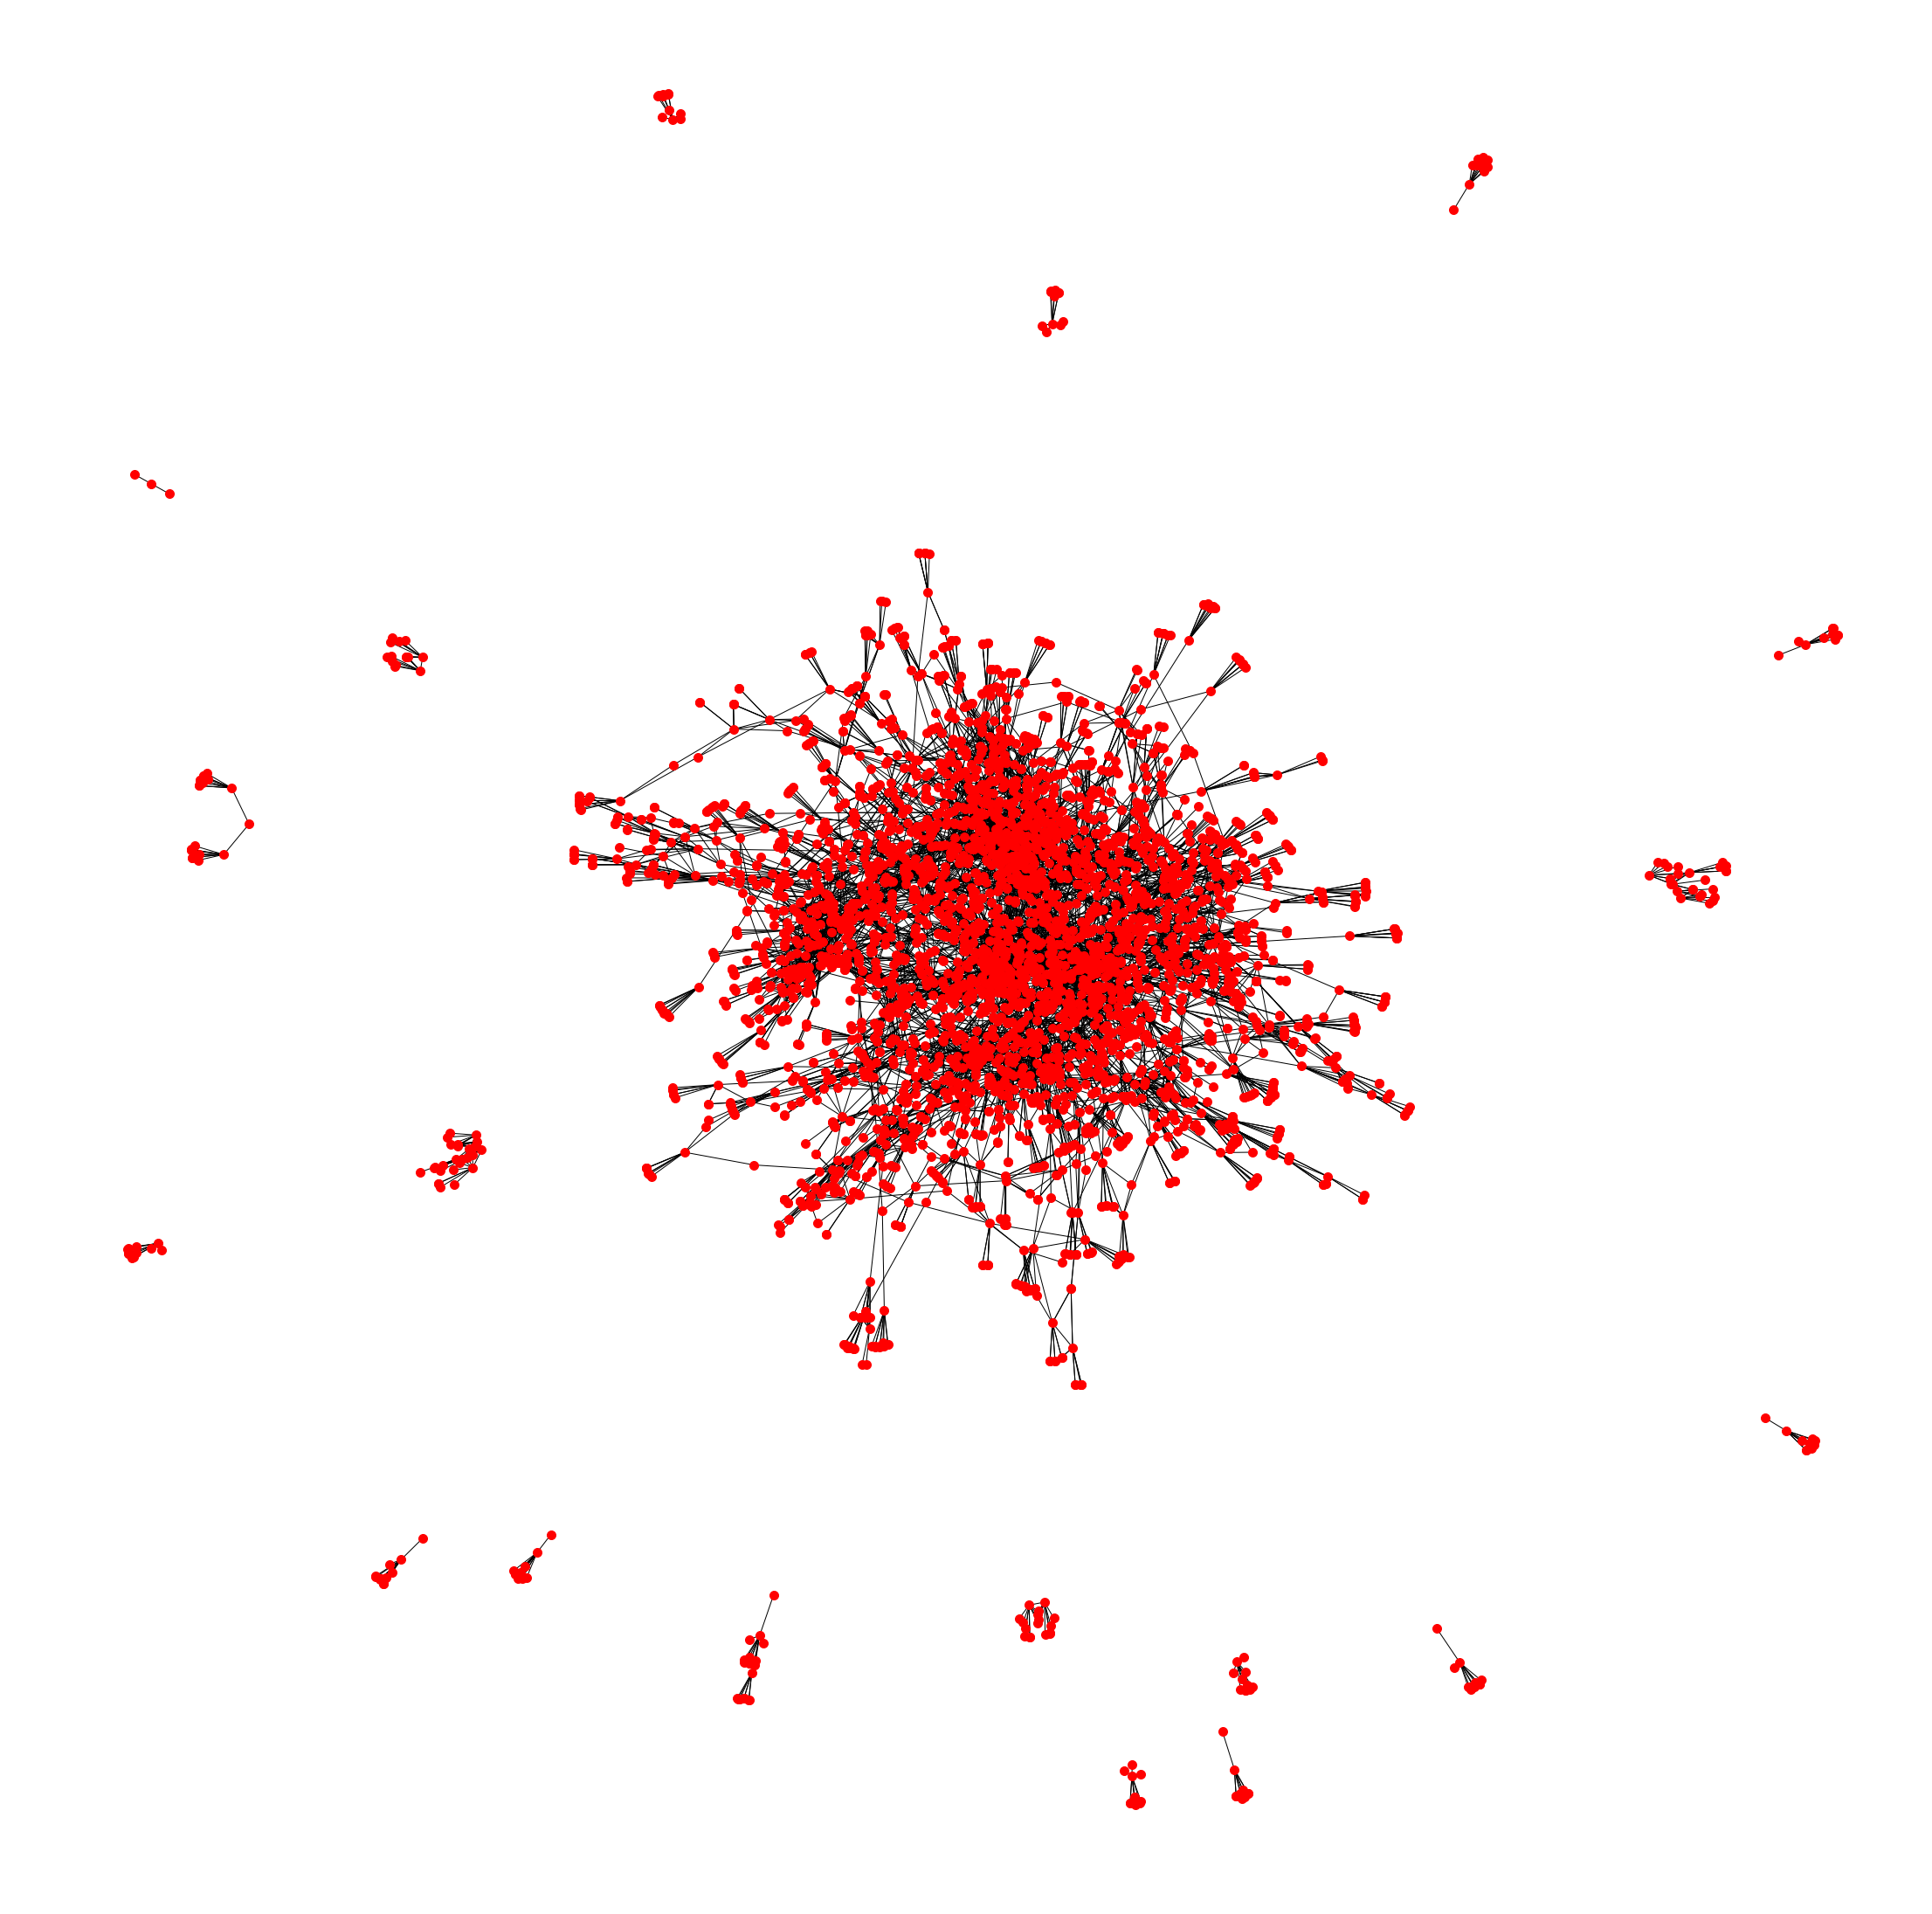

In [2]:
plt.figure(figsize=(30,30))
nx.draw(G_Music_Genre, layout=nx.spring_layout(G_Music_Genre, k=0.3*1/np.sqrt(len(G_Music_Genre.nodes()))), node_size=100)
# nx.draw(G_Music, with_labels=True,  k=0.3*1/np.sqrt(len(G.nodes())),node_color=color_list, iterations=20)

In [4]:
# modularity matrix, max eigenvalue, go to column of eigenvector, 
# split on positives and negatives
from collections import deque

def top_level_clustering(graph, k):
    # Queue for holding and processing communities
    processing_queue = deque([graph])
    # Keep taking community clusters off the front of the queue until we have k clusters
    while len(processing_queue) < k:
        # Take current community off front of the queue
        current_graph = processing_queue.popleft()
        # Cluster popped community into two communities based on modularity
        sub_communities = modularity_clustering_eigh(current_graph)
        # Put two communities you got back onto queue and keep going if number 
        # of communities < k
        processing_queue.append(current_graph.subgraph(sub_communities[0]))
        processing_queue.append(current_graph.subgraph(sub_communities[1]))
    # Return groups of nodes in each community as a list of lists
    return [list(G.nodes()) for G in processing_queue]

def modularity_clustering_eigh(graph):
    # Get graph's adjacency matrix
    A = nx.adjacency_matrix(graph)
    # Compute degree vector
    k = np.array(graph.degree(graph.nodes()))[:,1:].astype(int)
    # Compute degree transpose
    k_transpose = k.transpose()
    # Get number of edges for normalization
    m = graph.number_of_edges()
    # Compute Modularity Matrix
    B = A - ((1/(2*m))*(k*k_transpose))
    # Compute Eigenvalues and Eigenvectors
    l, U = la.eigh(B)
    # Use signs from largest eigenvalue's eigenvector to label each node
    # for community_1 or community_2
    labels = np.ravel(np.sign(U[:,-1]))
    # Make a list of nodes and two community lists to hold the two partitions
    nodes = list(graph.nodes())
    community_1 = []
    community_2 = []
    # Put each node in their respective group based on the labels
    for i in range(len(nodes)):
        if labels[i] > 0:
            community_1.append(nodes[i])
        else:
            community_2.append(nodes[i])
    # Return two community partitions in a tuple
    return community_1, community_2
    

# Print out graph to check clusterings
clusters = top_level_clustering(G_Music_Genre, 35)
labels = []
for node in G_Music_Genre.nodes():
    for i in range(len(clusters)):
        if node in clusters[i]:
            labels.append(i)

node_data['Modularity Community'] = labels
node_data.head()

Artist         Genre  Modularity Community
0                 Queen  classic rock                    33
1       Freddie Mercury  classic rock                    33
2             Brian May          rock                    33
3          Roger Taylor          rock                    33
4  Queen + Paul Rodgers          rock                    33

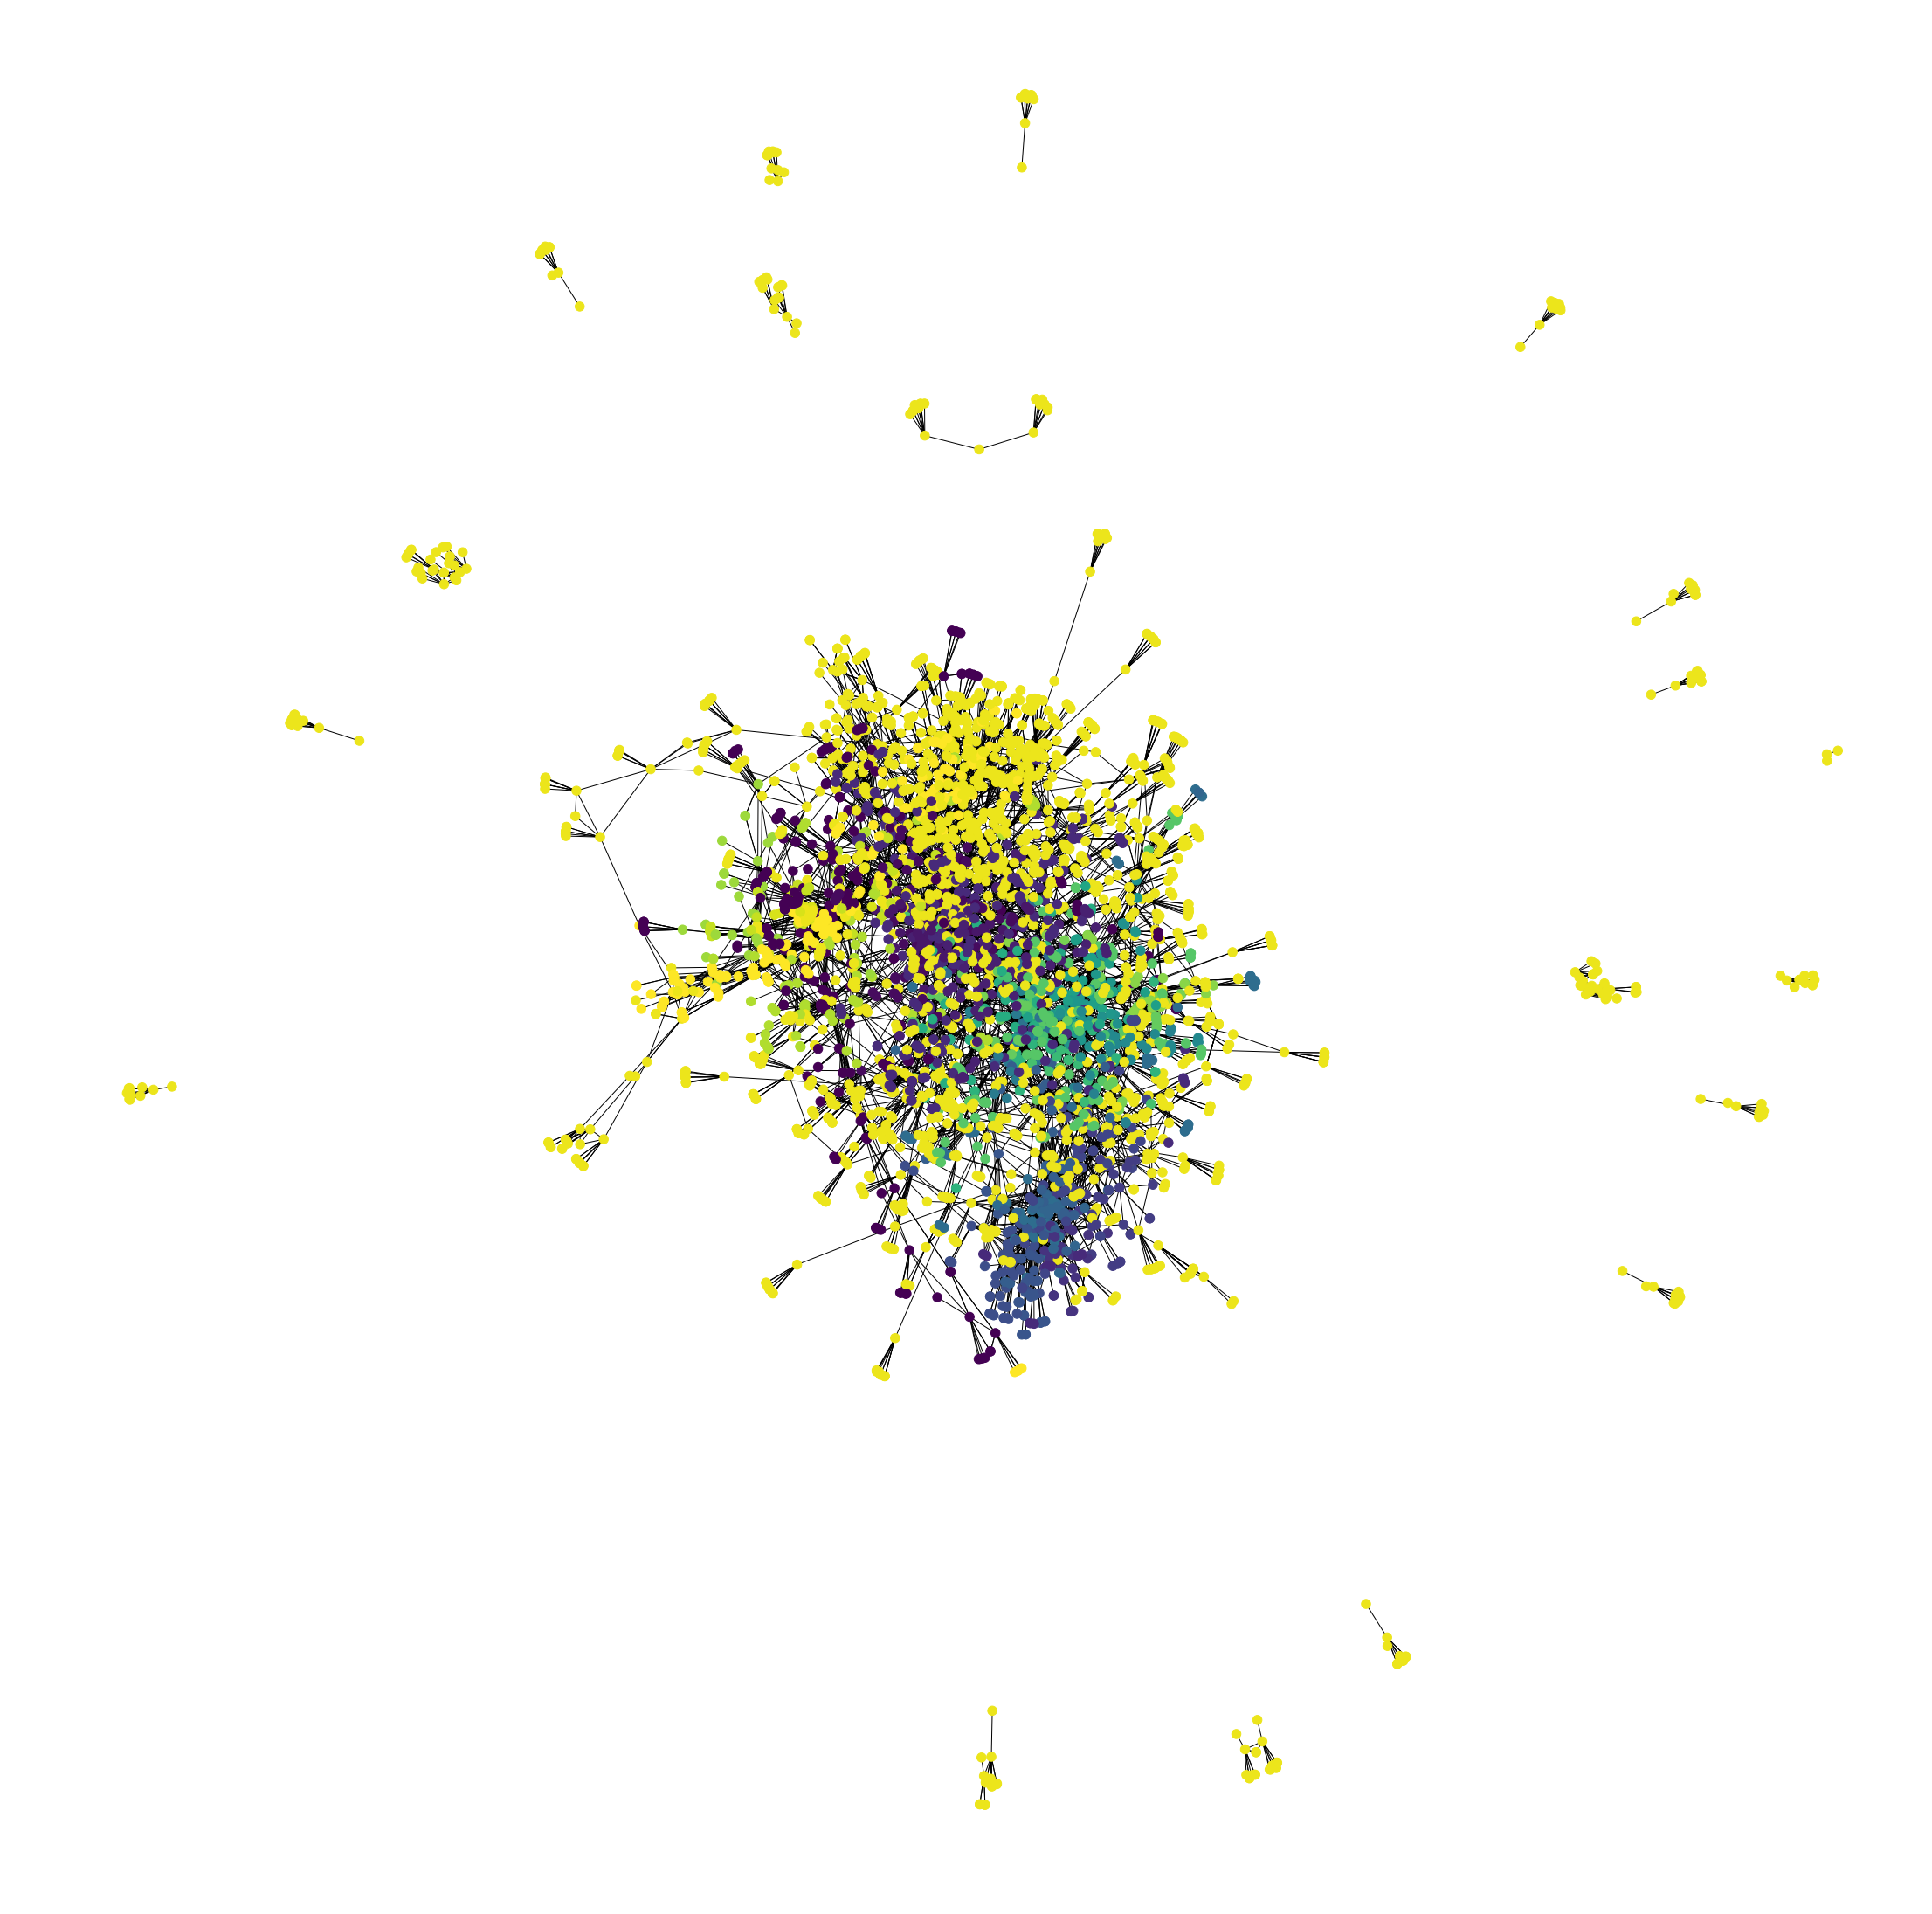

In [4]:
plt.figure(figsize = (30,30))
nx.draw(G_Music_Genre, layout=nx.spring_layout(G_Music_Genre, k=100), node_size=110, node_color=node_data['Modularity Community'])

Max # Genres in one cluster – 187.000000
Min # Genres in one cluster – 4.000000
Avg # Genres in clusters – 17.714286
Std Dev of Genres in clusters – 31.015718
Entropy of data – 2.701402


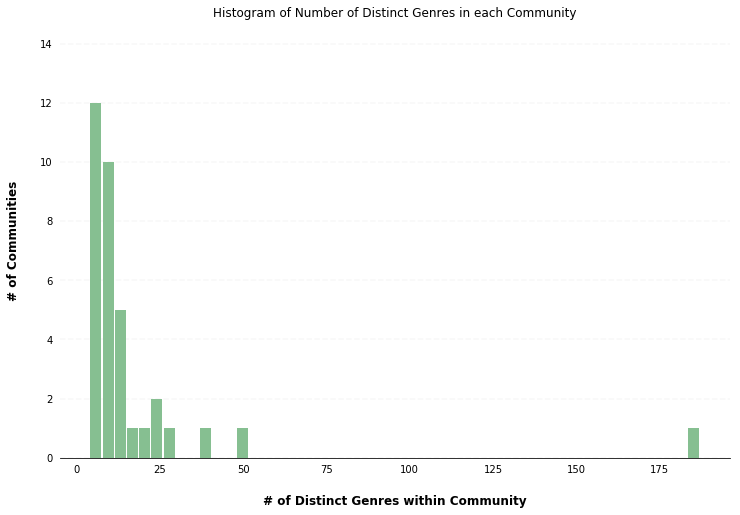

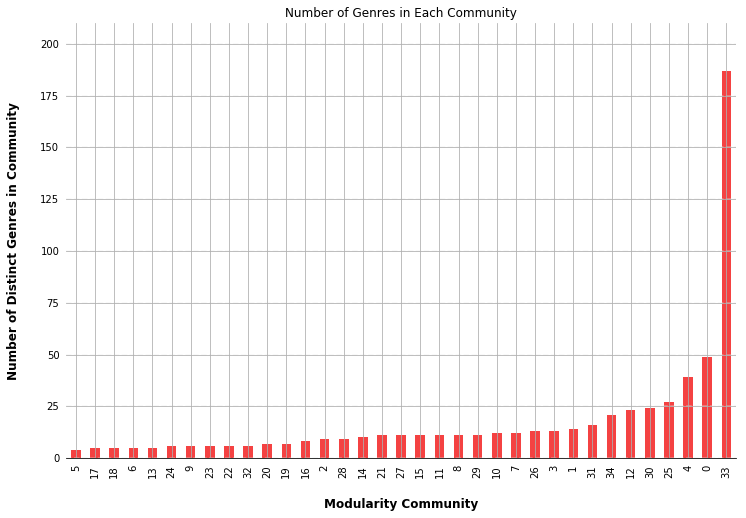

In [10]:
import scipy.stats as stats
import string

def compute_entropy(data):
    p_data= data.value_counts()/len(data) # calculates the probabilities
    entropy=stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy

def pretty_plot(_ax, title, x, y):
    # Despine
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    _ax.spines['left'].set_visible(False)

    # Switch off ticks
    _ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = _ax.get_yticks()
    for tick in vals:
        _ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    _ax.set_title(title)

    # Set x-axis label
    _ax.set_xlabel(x, labelpad=20, weight='bold', size=12)

    # Set y-axis label
    _ax.set_ylabel(y, labelpad=20, weight='bold', size=12)

community_labels = [s for s in string.ascii_lowercase+string.ascii_uppercase]
for z in zip(string.ascii_lowercase, string.ascii_lowercase):
    community_labels.append(z[0]+z[1])
for z in zip(string.ascii_uppercase, string.ascii_uppercase):
    community_labels.append(z[0]+z[1])    

modularity_communities_grouped = node_data.groupby('Modularity Community')['Genre'].nunique()
print('Max # Genres in one cluster – %f' % modularity_communities_grouped.max())
print('Min # Genres in one cluster – %f' % modularity_communities_grouped.min())
print('Avg # Genres in clusters – %f' % modularity_communities_grouped.mean())
print('Std Dev of Genres in clusters – %f' % modularity_communities_grouped.std())
print('Entropy of data – %f' % compute_entropy(modularity_communities_grouped))

pretty_plot(modularity_communities_grouped.hist(bins=50, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9), 'Histogram of Number of Distinct Genres in each Community', '# of Distinct Genres within Community', '# of Communities')
plt.show()
pretty_plot(modularity_communities_grouped.sort_values().plot(kind='bar', grid=True, figsize=(12,8), color='#f44242'), 'Number of Genres in Each Community', 'Modularity Community', 'Number of Distinct Genres in Community')


In [36]:
df = node_data.groupby(['Spectral Community','Genre']).count()
df.ix[8].nlargest(30, columns='Artist')

Artist  Modularity Community  Betweenness Community
Genre                                                             
electronic         38                    38                     38
trip-hop           22                    22                     22
Drum and bass      13                    13                     13
country             9                     9                      9
reggae              7                     7                      7
downtempo           6                     6                      6
ambient             5                     5                      5
chillout            3                     3                      3
ska                 3                     3                      3
turntablism         2                     2                      2
jazz                1                     1                      1
ninja tune          1                     1                      1
idm                 1                     1                      1
seen live           1                     1                      1
Hip-Hop             1                     1                      1
dubstep             1                     1                      1
folk                1                     1                      1

In [21]:
# Read in snap betweeness Results
clusters = []
# with open('/Users/ricky/Desktop/School/FL2018/CSE416/final-project/More Betweeness Community.txt', 'r') as textFile:
#     clusters = np.array([node_list.split(',') for node_list in textFile.read().split('\n')])
#     clusters = [[int(node) for node in node_list] for node_list in clusters]
    
    
with open('/Users/ricky/Desktop/School/FL2018/CSE416/final-project/betweenness_communities.txt', 'r') as fp:
    for line in fp:
        clusters.append([int(int_string) for int_string in line.split(',')])

labels = []
for node in G_Music_Genre.nodes():
    for i in range(len(clusters)):
        if node in clusters[i]:
            labels.append(i)
labels.append(len(clusters)-1)

node_data['Betweenness Community'] = labels
node_data.head()

Artist         Genre  Modularity Community  \
0                 Queen  classic rock                    33   
1       Freddie Mercury  classic rock                    33   
2             Brian May          rock                    33   
3          Roger Taylor          rock                    33   
4  Queen + Paul Rodgers          rock                    33   

   Spectral Community  Betweenness Community  
0                   2                      2  
1                   2                      2  
2                   2                      2  
3                   2                      2  
4                   2                      2

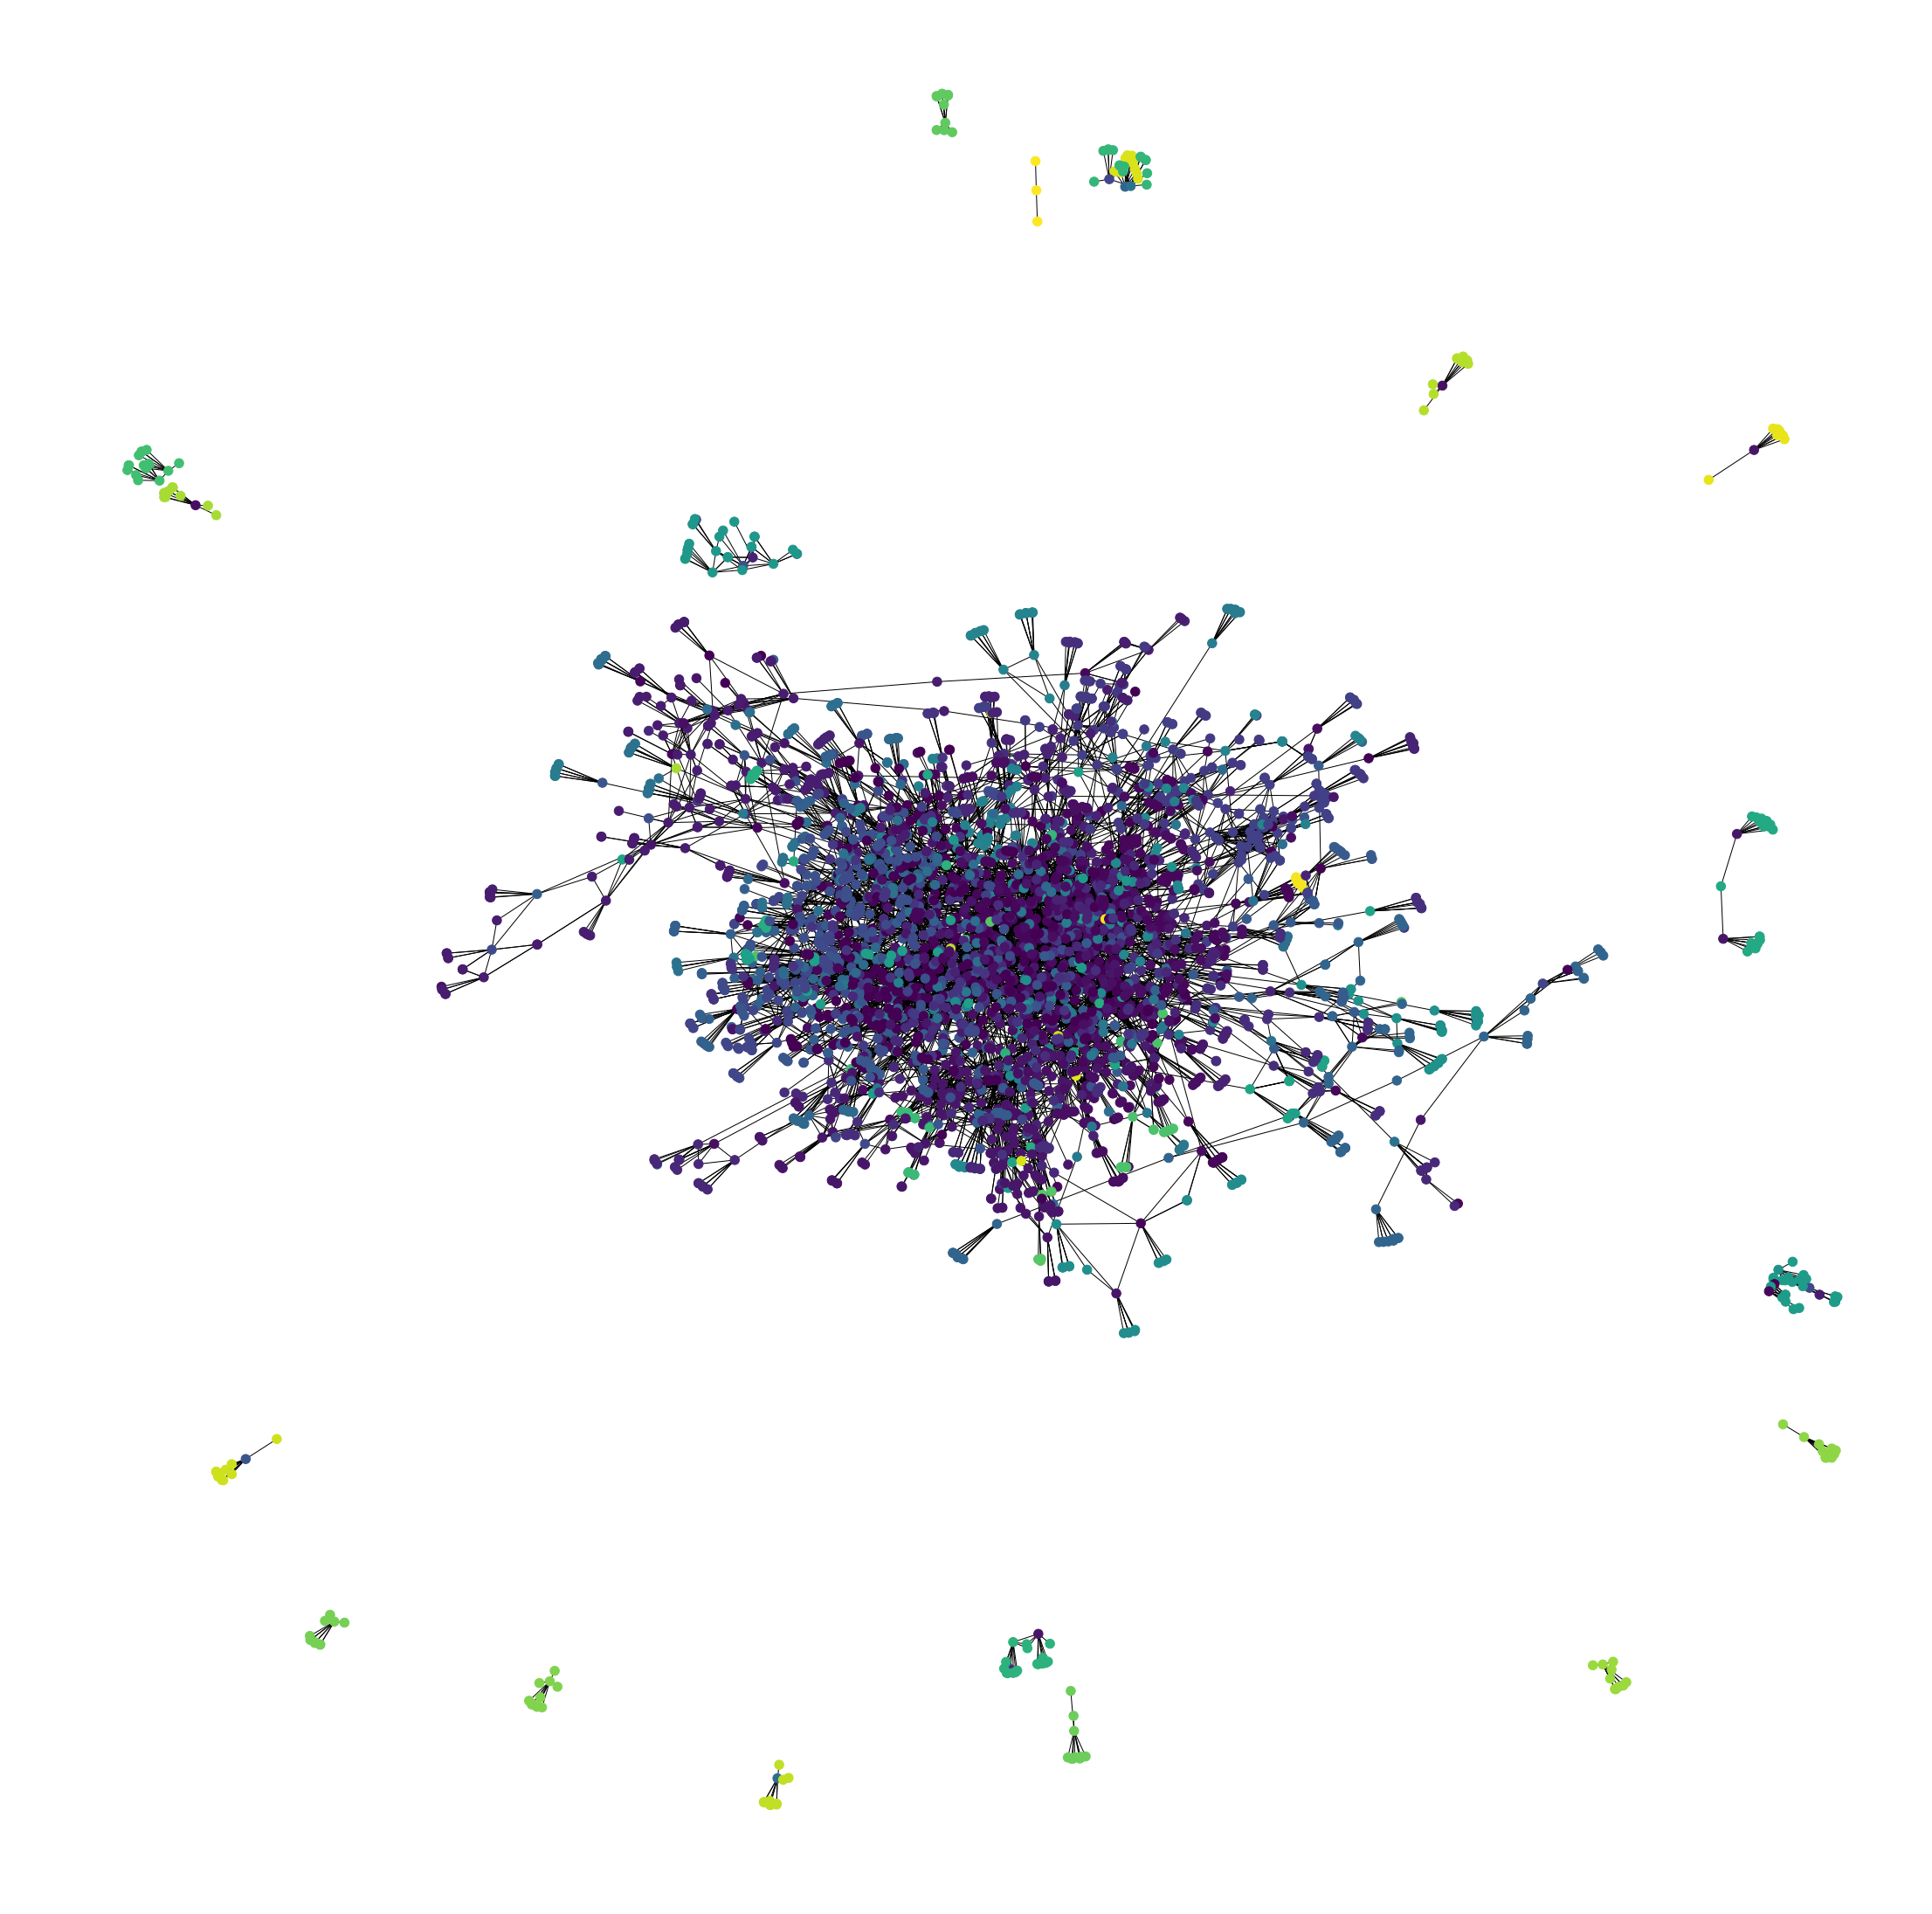

In [7]:
plt.figure(figsize = (30,30))
nx.draw(G_Music_Genre, layout=nx.spring_layout(G_Music_Genre, k=100), node_size=110, node_color=node_data['Betweenness Community'])

Max # Genres in one cluster – 67.000000
Min # Genres in one cluster – 2.000000
Avg # Genres in one cluster – 17.981481
Std Dev of Genres in one cluster – 16.887520
Entropy of data – 3.175382


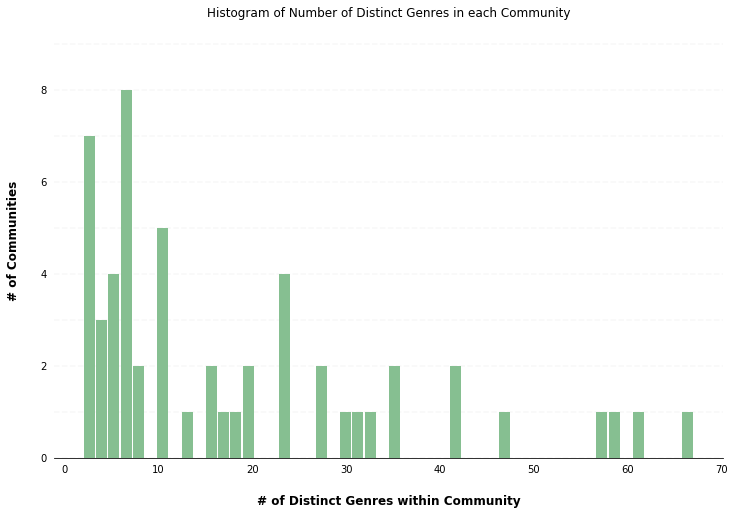

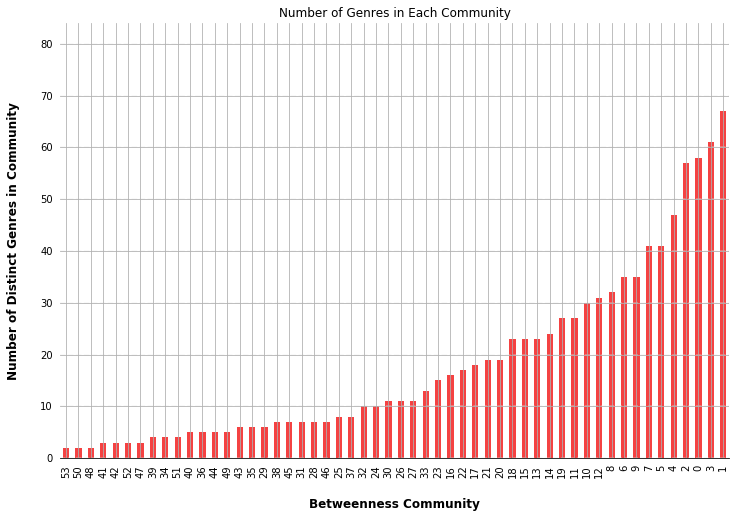

In [8]:
betweenness_communities_grouped = node_data.groupby('Betweenness Community')['Genre'].nunique()
print('Max # Genres in one cluster – %f' % betweenness_communities_grouped.max())
print('Min # Genres in one cluster – %f' % betweenness_communities_grouped.min())
print('Avg # Genres in one cluster – %f' % betweenness_communities_grouped.mean())
print('Std Dev of Genres in one cluster – %f' % betweenness_communities_grouped.std())
print('Entropy of data – %f' % compute_entropy(betweenness_communities_grouped))

pretty_plot(betweenness_communities_grouped.hist(bins=50, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9), 'Histogram of Number of Distinct Genres in each Community', '# of Distinct Genres within Community', '# of Communities')
plt.show()
pretty_plot(betweenness_communities_grouped.sort_values().plot(kind='bar', grid=True, figsize=(12,8), color='#f44242'), 'Number of Genres in Each Community', 'Betweenness Community', 'Number of Distinct Genres in Community')



In [5]:
def spectral_cluster(graph, k):
    # Create 'graphs' adjacency matrix
    A = nx.adjacency_matrix(graph)
    # Calculate Degree Matrix from adjacency matrix
    D = np.diag(np.ravel(np.sum(A, axis=1)))
    # Calculate Laplacian from Degree and Adjacency matricies
    L = D - A
    # Compute eigenvalues and eigenvectors of the Laplacian matrix
    l, U = la.eigh(L)
    if k > 2:
        # Use k-means clustering on the rows of the matrix to extract clusters
        means, labels = vq.kmeans2(U[:,1:k], k)
    else:
        # Grab the "Fiedler" vector (second smallest eigenvalue's eigenvector)
        f = U[:,1]
        # Use f to partition graph by the sign of the scalars in the vector
        labels = np.ravel(np.sign(f))
    # Create empty communities list to store nodes
    communities = [[] for _ in range(k)]
    nodes = list(graph.nodes())
    # Group nodes into community lists based on 'labels' variable
    for i in range(len(nodes)):
        if labels[i] < 0:
            communities[0].append(nodes[i])
        else:
            communities[int(labels[i])].append(nodes[i])
    # Return community groups
    return communities

# Print samples
spectral_clusters = spectral_cluster(G_Music_Genre, 54)
labels = []
for node in G_Music_Genre.nodes():
    for i in range(len(spectral_clusters)):
        if node in spectral_clusters[i]:
            labels.append(i)
            
node_data['Spectral Community'] = labels
print(node_data['Spectral Community'].nunique())
node_data.head()
# coord = nx.spring_layout(G_Music_Genre, k=100)
# fig = plt.figure()
# axs = fig.add_subplot(111, aspect='equal')
# axs.axis('off')
# nx.draw_networkx_edges(G_Music_Genre, coord)
# nx.draw_networkx_nodes(G_Music_Genre, coord, node_size=5, node_color=labels)
# plt.show()

41


Artist         Genre  Modularity Community  \
0                 Queen  classic rock                    33   
1       Freddie Mercury  classic rock                    33   
2             Brian May          rock                    33   
3          Roger Taylor          rock                    33   
4  Queen + Paul Rodgers          rock                    33   

   Spectral Community  
0                   2  
1                   2  
2                   2  
3                   2  
4                   2

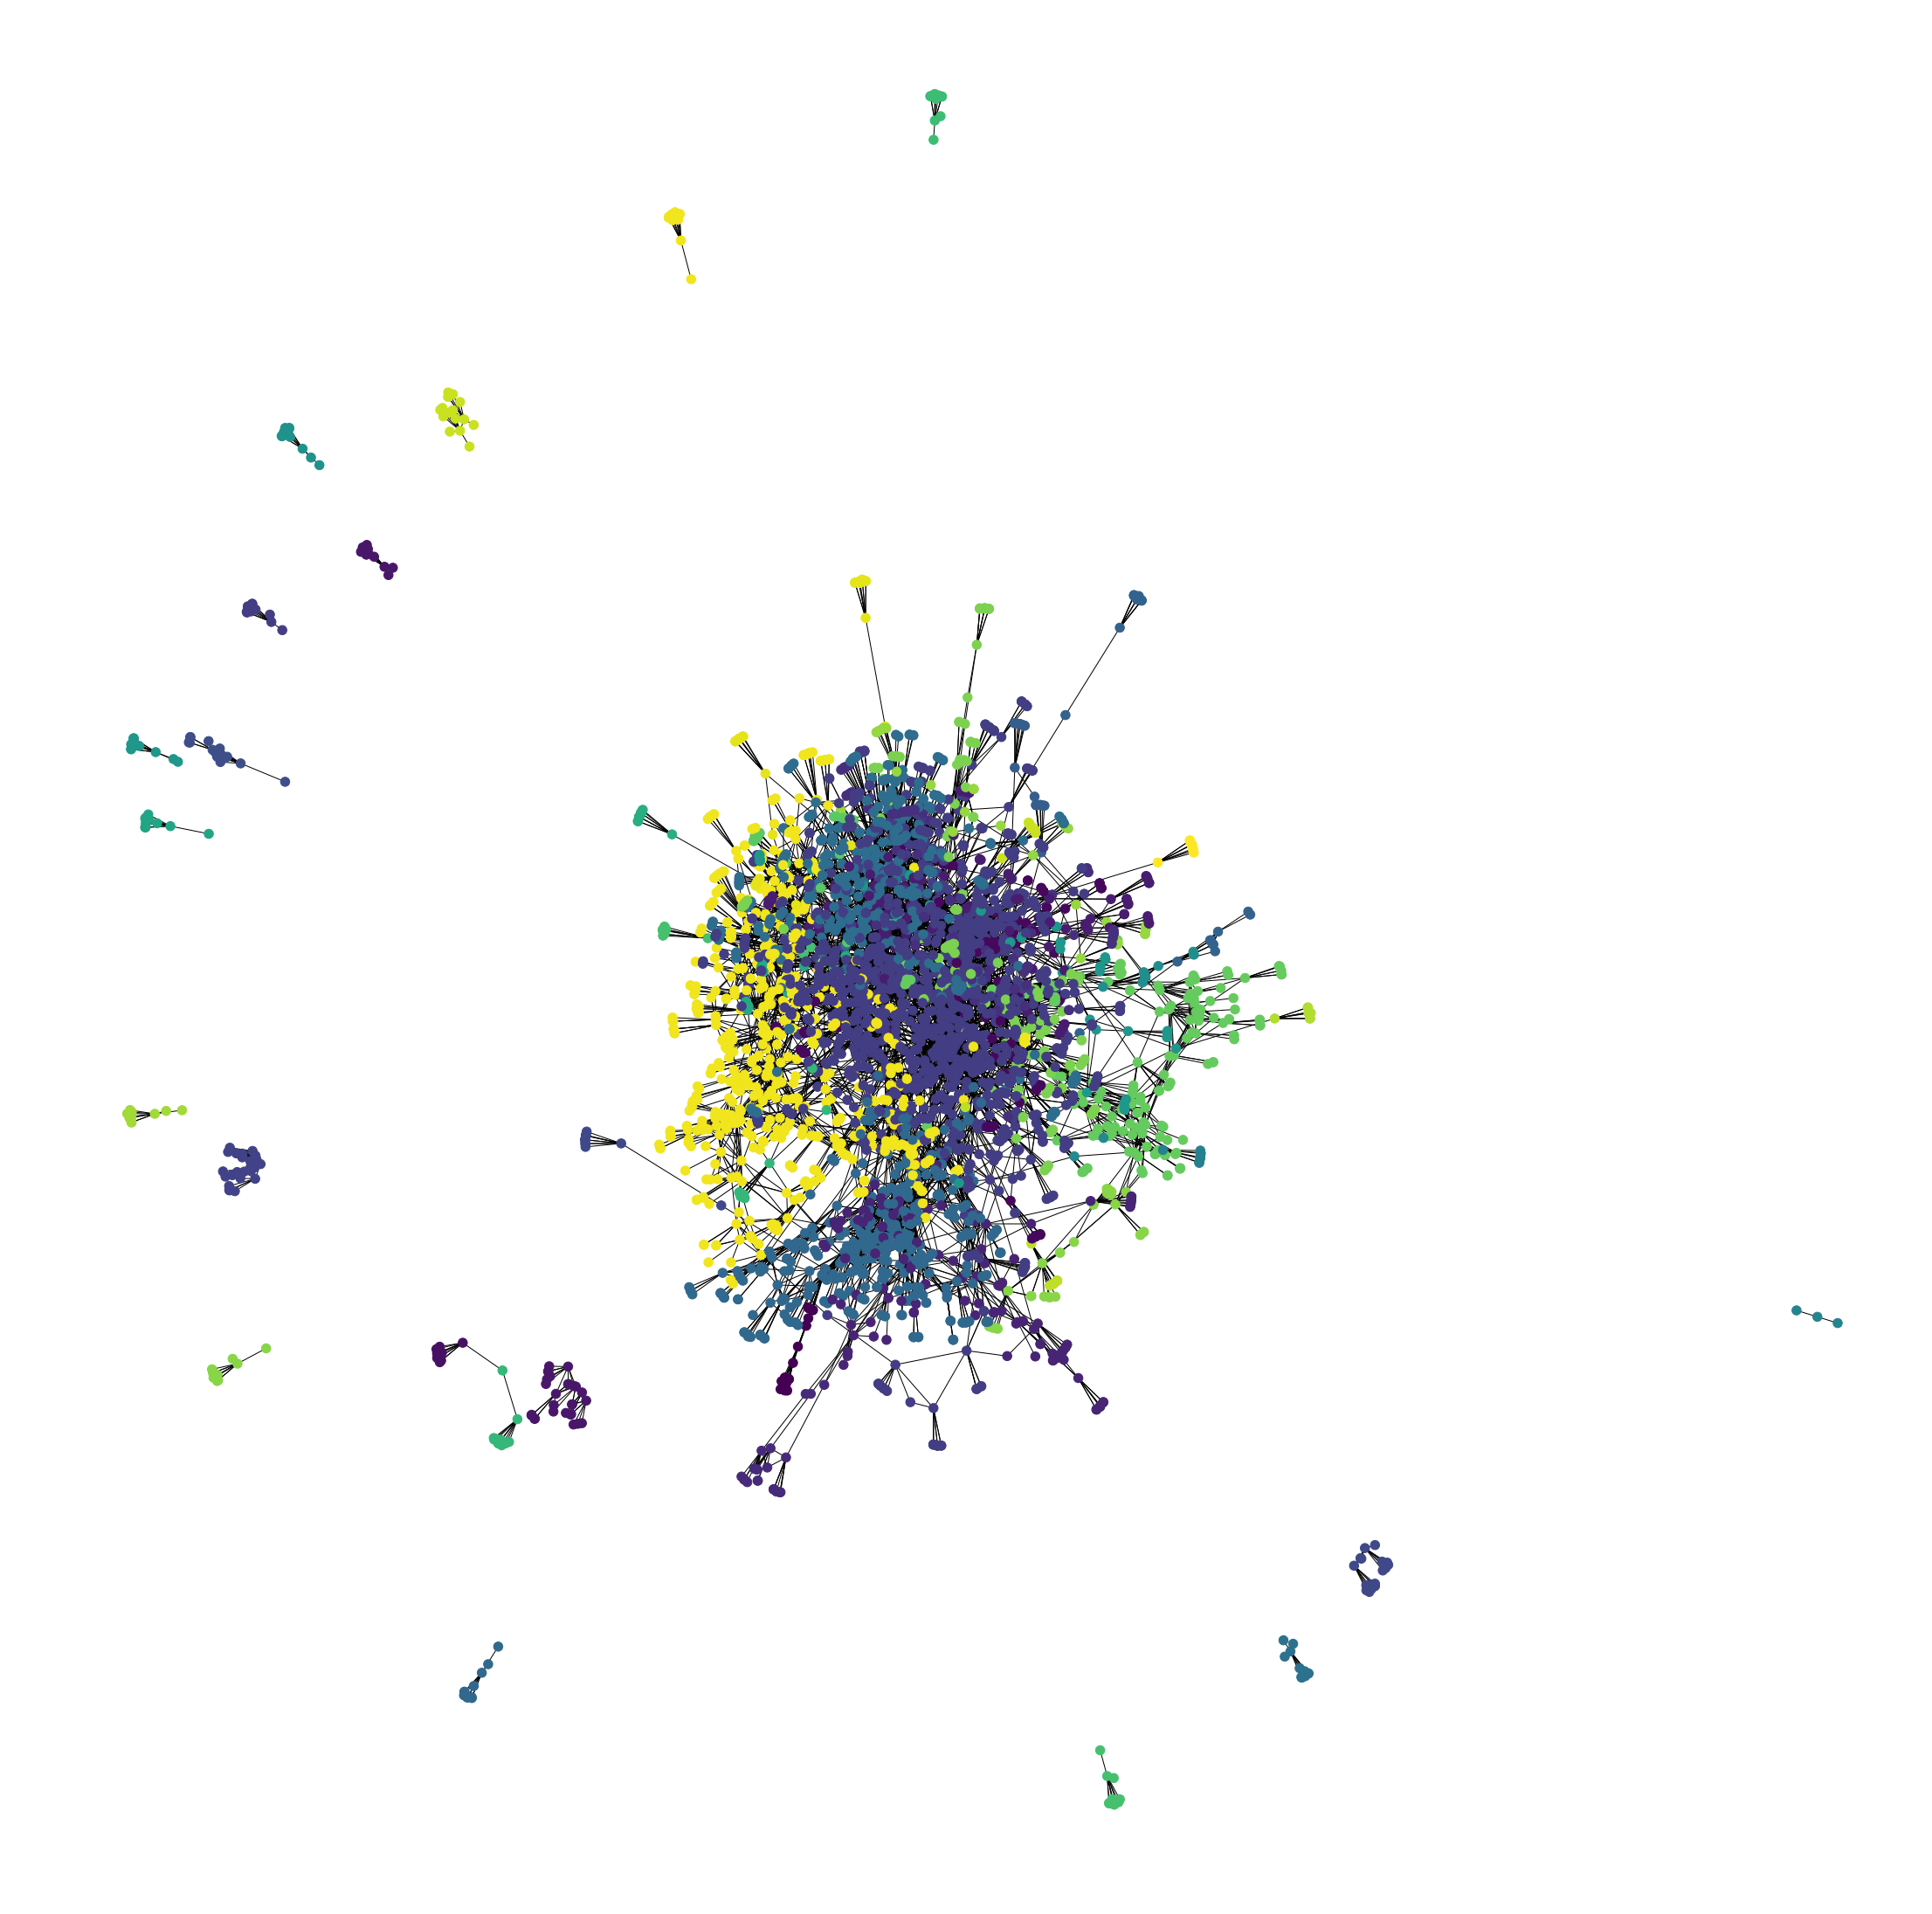

In [10]:
plt.figure(figsize = (30,30))
nx.draw(G_Music_Genre, layout=nx.spring_layout(G_Music_Genre, k=100), node_size=110, node_color=node_data['Spectral Community'])

Max # Genres in one cluster – 102.000000
Min # Genres in one cluster – 1.000000
Avg # Genres in one cluster – 13.000000
Std Dev of Genres in one cluster – 18.785633
Entropy of data – 2.794213


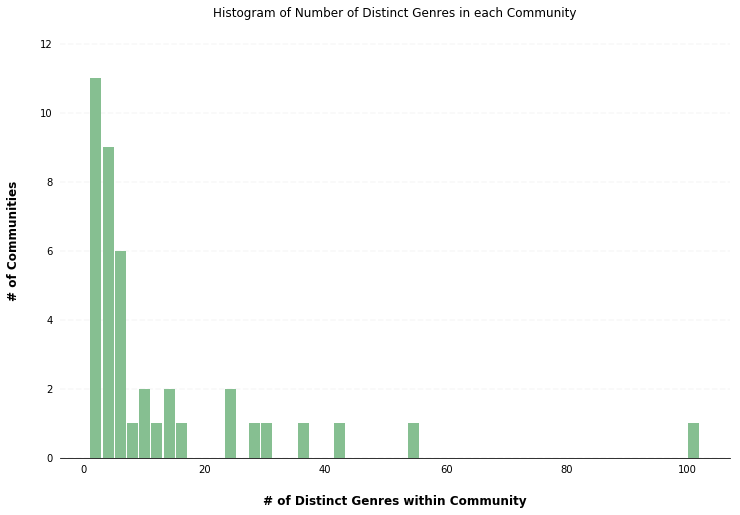

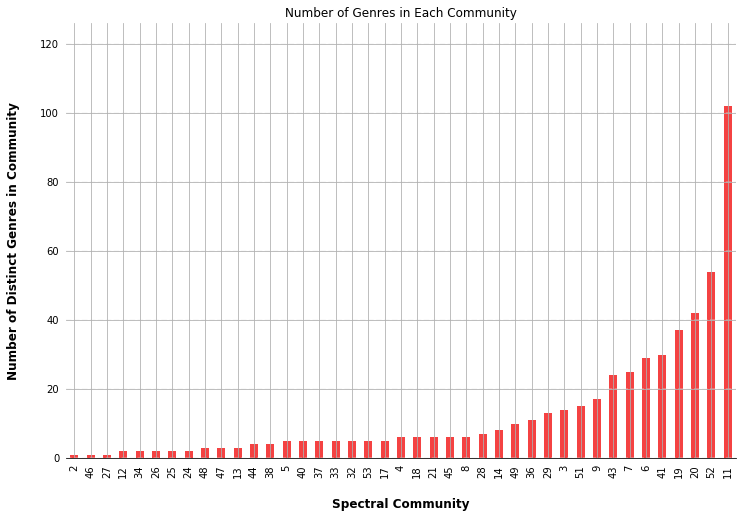

In [11]:
spectral_communities_grouped = node_data.groupby('Spectral Community')['Genre'].nunique()
print('Max # Genres in one cluster – %f' % spectral_communities_grouped.max())
print('Min # Genres in one cluster – %f' % spectral_communities_grouped.min())
print('Avg # Genres in one cluster – %f' % spectral_communities_grouped.mean())
print('Std Dev of Genres in one cluster – %f' % spectral_communities_grouped.std())
print('Entropy of data – %f' % compute_entropy(spectral_communities_grouped))

pretty_plot(spectral_communities_grouped.hist(bins=50, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9), 'Histogram of Number of Distinct Genres in each Community', '# of Distinct Genres within Community', '# of Communities')
plt.show()
pretty_plot(spectral_communities_grouped.sort_values().plot(kind='bar', grid=True, figsize=(12,8), color='#f44242'), 'Number of Genres in Each Community', 'Spectral Community', 'Number of Distinct Genres in Community')



In [6]:
from networkx.algorithms.community.quality import modularity
import time
import warnings
warnings.filterwarnings('ignore')


modularity_scores_modularity_clustering = [modularity(G_Music_Genre, top_level_clustering(G_Music_Genre, k)) for k in range(5, 100, 5)]
modularity_scores_series = pd.Series(modularity_scores_modularity_clustering, index=pd.RangeIndex(5,100,5))


modularity_scores_spectral_clustering = [modularity(G_Music_Genre, spectral_cluster(G_Music_Genre, k)) for k in range(5, 100, 5)]
spectral_scores_series = pd.Series(modularity_scores_spectral_clustering, index=pd.RangeIndex(5,100,5))


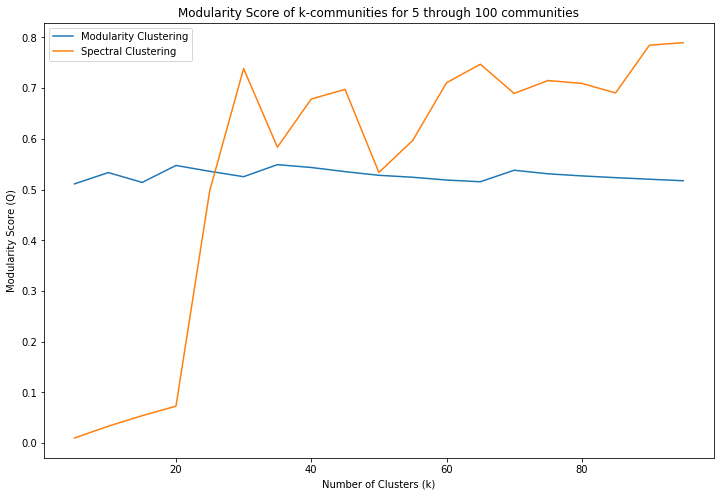

modularity clustering max k= 35 Q – 0.5491425852949535
spectral clustering max k= 95 Q – 0.7897306830539893


In [9]:
ax = modularity_scores_series.plot(kind='line', figsize=(12,8), use_index=True, label='Modularity Clustering')
ax.set(title='Modularity Score of k-communities for 5 through 100 communities', xlabel='Number of Clusters (k)', ylabel='Modularity Score (Q)')

ax = spectral_scores_series.plot(kind='line', figsize=(12,8), use_index=True, label='Spectral Clustering')
ax.set(title='Modularity Score of k-communities for 5 through 100 communities', xlabel='Number of Clusters (k)', ylabel='Modularity Score (Q)')
ax.legend()
plt.show()

# ax = modularity_scores_series.plot(kind='line', figsize=(12,8), use_index=True, label='Modularity Clustering')
# ax.set(title='Modularity', xlabel='Number of Clusters (k)', ylabel='Modularity Score (Q)')

# # plt.show()

# ax = spectral_scores_series.plot(kind='line', figsize=(12,8), use_index=True, label='Spectral Clustering')
# ax.set(xlabel='Number of Clusters (k)', ylabel='Modularity Score (Q)')
# ax.legend()

m_idx = modularity_scores_series.idxmax()
s_idx = spectral_scores_series.idxmax()

print('modularity clustering max k=', m_idx, 'Q –', modularity_scores_series[m_idx])
print('spectral clustering max k=', s_idx, 'Q –', spectral_scores_series[s_idx])

In [14]:
m_idx = modularity_scores_series.idxmax()
s_idx = spectral_scores_series.idxmax()

print('modularity clustering max k, Q –', str(m_idx) + ',', modularity_scores_series[m_idx])
print('spectral clustering max k, Q –', str(s_idx) + ',', spectral_scores_series[s_idx])

modularity clustering max k, Q – 35, 0.5491425852949535
spectral clustering max k, Q – 90, 0.8077663679202556


In [15]:
modularity_scores_modularity_clustering_2 = [modularity(G_Music_Genre, top_level_clustering(G_Music_Genre, k)) for k in range(25, 45)]
modularity_scores_series_2 = pd.Series(modularity_scores_modularity_clustering_2, index=pd.RangeIndex(25, 45))


modularity_scores_spectral_clustering_2 = [modularity(G_Music_Genre, spectral_cluster(G_Music_Genre, k)) for k in range(70, 90)]
spectral_scores_series_2 = pd.Series(modularity_scores_spectral_clustering_2, index=pd.RangeIndex(70, 90))



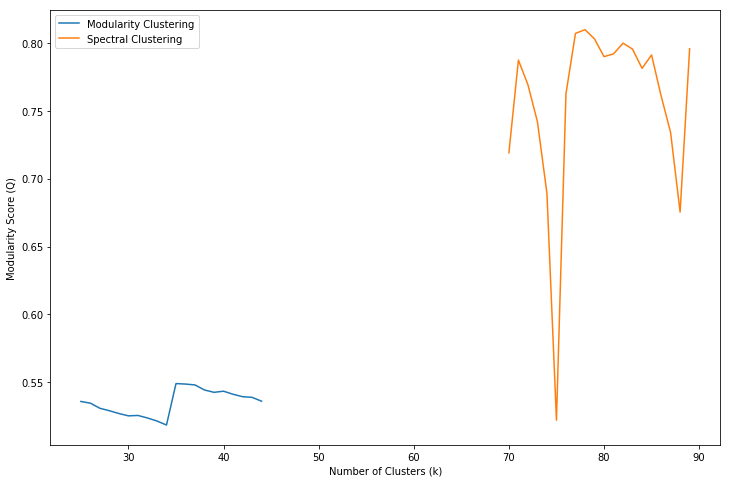

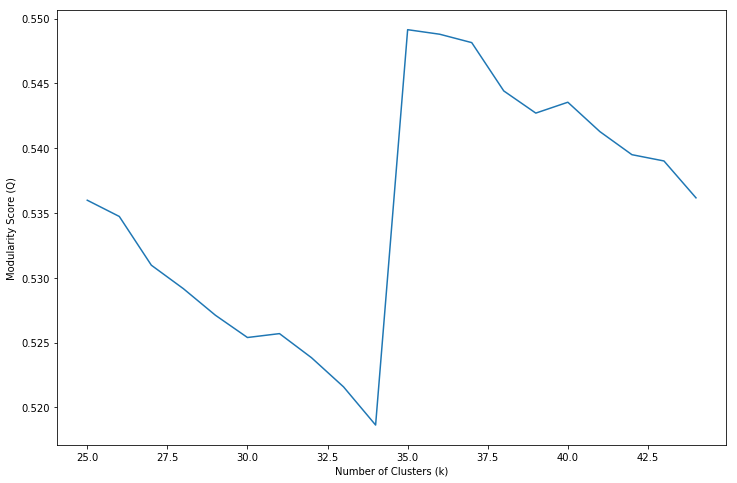

modularity clustering max k= 35 Q – 0.5491425852949535
spectral clustering max k= 78 Q – 0.809649632821596


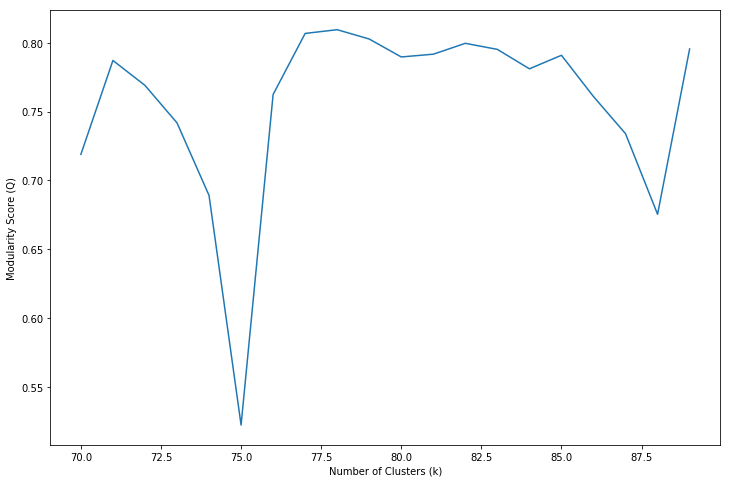

In [35]:
ax = modularity_scores_series_2.plot(kind='line', figsize=(12,8), use_index=True, label='Modularity Clustering')
ax.set(title='Modularity Score of k-communities for 5 through 100 communities', xlabel='Number of Clusters (k)', ylabel='Modularity Score (Q)')

ax = spectral_scores_series_2.plot(kind='line', figsize=(12,8), use_index=True, label='Spectral Clustering')
ax.set(xlabel='Number of Clusters (k)', ylabel='Modularity Score (Q)')
ax.legend()

# plt.show()

# ax = modularity_scores_series_2.plot(kind='line', figsize=(12,8), use_index=True)
# ax.set(xlabel='Number of Clusters (k)', ylabel='Modularity Score (Q)')

# plt.show()

# ax = spectral_scores_series_2.plot(kind='line', figsize=(12,8), use_index=True)
# ax.set(xlabel='Number of Clusters (k)', ylabel='Modularity Score (Q)')

m_idx_2 = modularity_scores_series_2.idxmax()
s_idx_2 = spectral_scores_series_2.idxmax()

print('modularity clustering max k=', m_idx_2, 'Q –', modularity_scores_series_2[m_idx_2])
print('spectral clustering max k=', s_idx_2, 'Q –', spectral_scores_series_2[s_idx_2])

Avg Modularity Clustering time –  97.12300599999999
Avg Modularity Clustering time –  97.12300599999999


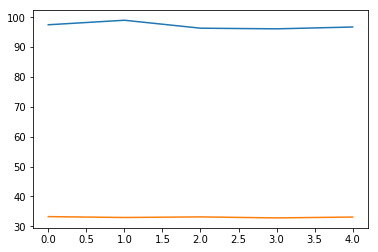

In [18]:
def time_betweeness_clustering(graph, k):
    times = []
    for _ in range(5):
        start = time.clock()
        betweeness_clustering(graph, k)
        end = time.clock()
        times.append(end - start)
    return (np.mean(times), times)
        
def time_modularity_clustering(graph, k):
    times = []
    for _ in range(5):
        start = time.clock()
        top_level_clustering(graph, k)
        end = time.clock()
        times.append(end - start)
    return (np.mean(times), times)

def time_spectral_clustering(graph, k):
    times = []
    for _ in range(5):
        start = time.clock()
        spectral_cluster(graph, k)
        end = time.clock()
        times.append(end - start)
    return (np.mean(times), times)



modularity_avg_time, modularity_times = time_modularity_clustering(G_Music_Genre, 35)
modularity_series = pd.Series(data=modularity_times)
spectral_avg_time, spectral_times = time_spectral_clustering(G_Music_Genre, 80)
spectral_series = pd.Series(data=spectral_times)

print('Avg Modularity Clustering time – ', modularity_avg_time)
print('Avg Modularity Clustering time – ', modularity_avg_time)

modularity_series.plot(kind='line', use_index=True)
spectral_series.plot(kind='line', use_index=True)

# concatted = pd.concat([{'Modularity Clustering Times': modularity_series, 'Spectral Clustering Times': spectral_series}, axis=1)


In [23]:
print('Avg Modularity Clustering time – ', modularity_avg_time)
print('Avg Spectral Clustering time – ', spectral_avg_time)

Avg Modularity Clustering time –  97.12300599999999
Avg Spectral Clustering time –  33.02234779999999


[Text(0, 0.5, 'Run Time'),
 Text(0.5, 0, 'Run #'),
 Text(0.5, 1.0, 'Cluster Script Run Times (5 run average)')]

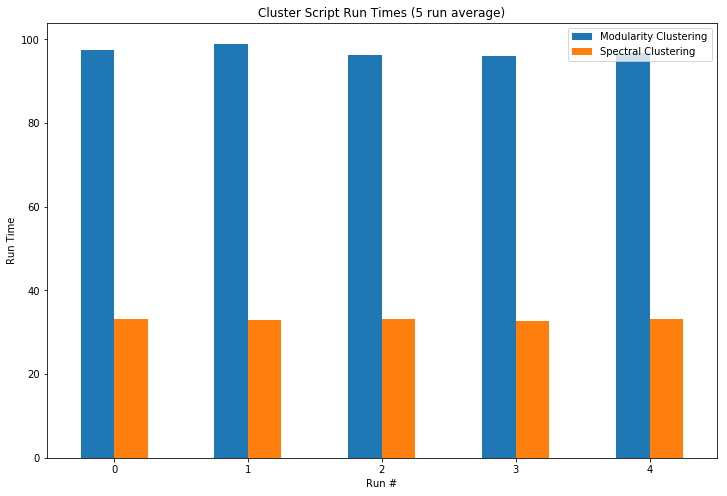

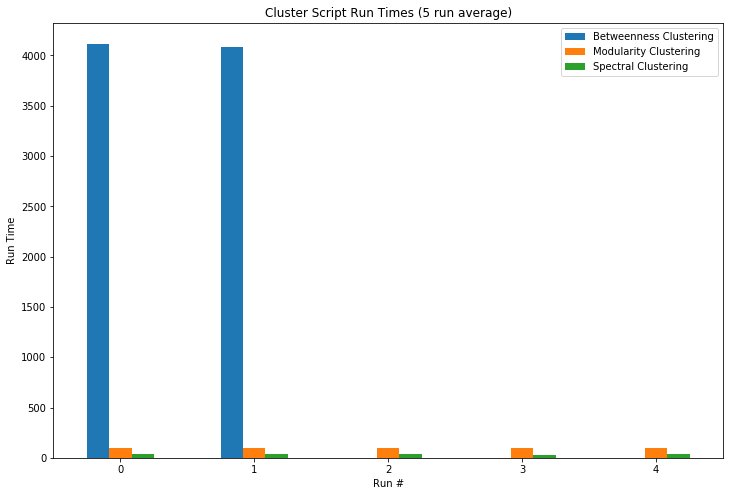

In [19]:
betweenness_series = pd.Series(data=[4117.163704, 4081.453254, np.nan, np.nan, np.nan])
concatted_2 = pd.concat({'Modularity Clustering': modularity_series, 'Spectral Clustering': spectral_series}, axis=1)
concatted_3 = pd.concat({'Modularity Clustering': modularity_series, 'Spectral Clustering': spectral_series, 'Betweenness Clustering': betweenness_series}, axis=1)

ax = concatted_2.plot.bar(rot=0, figsize=(12,8))
ax.set(title='Cluster Script Run Times (5 run average)', xlabel='Run #', ylabel='Run Time')

ax = concatted_3.plot.bar(rot=0, figsize=(12,8))
ax.set(title='Cluster Script Run Times (5 run average)', xlabel='Run #', ylabel='Run Time')

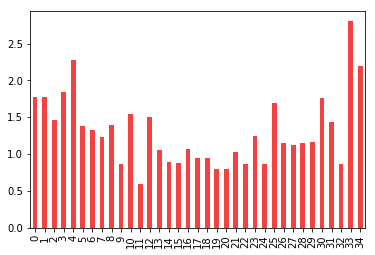

[Text(0, 0.5, 'Number of Distinct Atrists or Genres'),
 Text(0.5, 0, 'Modularity Community')]

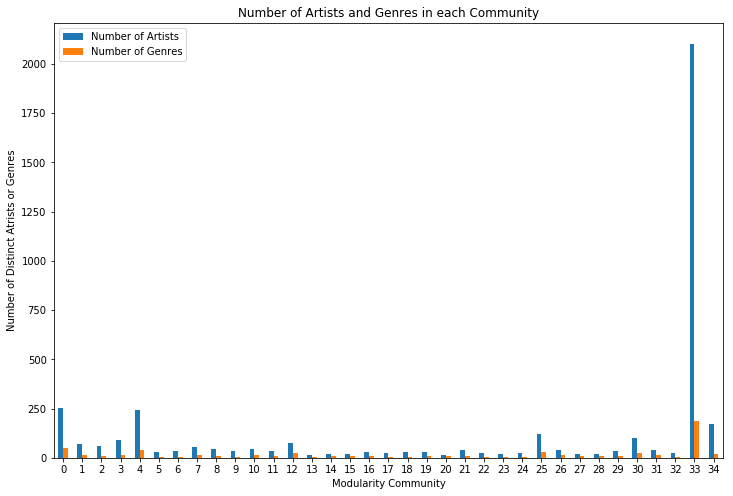

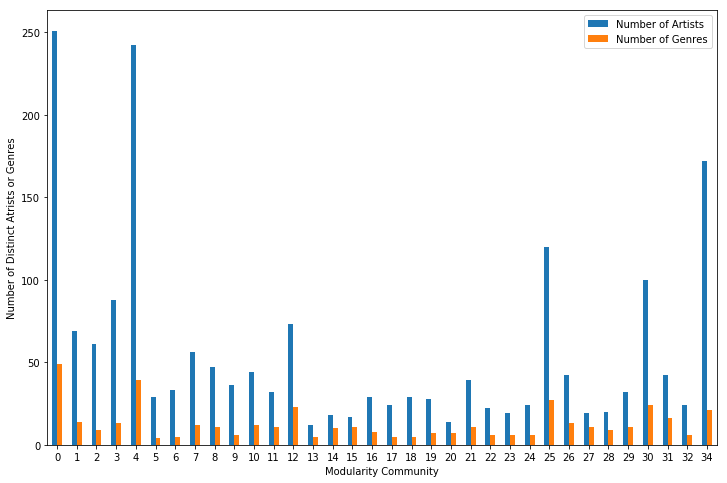

In [50]:
import matplotlib.mlab as mlab

grouped_modularity = node_data.groupby(['Modularity Community', 'Genre']).size()

modularity_community_entropies = pd.Series([compute_entropy(cmty) for idx, cmty in grouped_modularity.groupby(level=0)])
# print(community_entropies)
# string.ascii_lowercase()
modularity_community_entropies.plot(kind='bar', color='#f44242', use_index=True)
plt.show()
# mu = community_entropies.mean()
# sigma = community_entropies.std()
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# plt.plot(x,mlab.normpdf(x, mu, sigma))
# plt.show()
num_genres = [cmty.count() for idx, cmty in grouped_modularity.groupby(level=0)]
num_artists = pd.Series([cmty.sum() for idx, cmty in grouped_modularity.groupby(level=0)])
plot_data = pd.DataFrame(data={'Number of Artists': num_artists, 'Number of Genres': num_genres})
ax = plot_data.plot.bar(rot=0, figsize=(12,8))
ax.set(title='Number of Artists and Genres in each Community', xlabel='Modularity Community', ylabel='Number of Distinct Atrists or Genres')
plot_data = plot_data.drop(33)
ax = plot_data.plot.bar(rot=0, figsize=(12,8))
ax.set(xlabel='Modularity Community', ylabel='Number of Distinct Atrists or Genres')

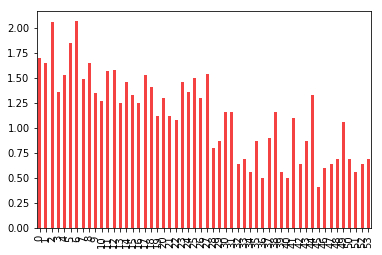

[Text(0, 0.5, 'Number of Distinct Atrists or Genres'),
 Text(0.5, 0, 'Betweenness Community')]

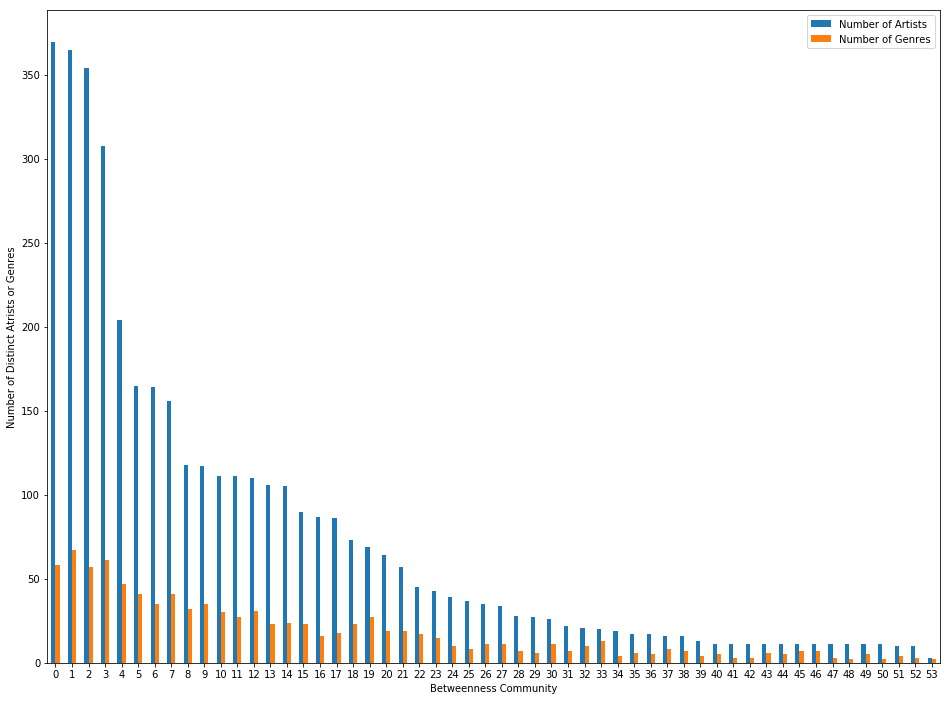

In [51]:
grouped_betweenness = node_data.groupby(['Betweenness Community', 'Genre']).size()

betweenness_community_entropies = pd.Series([compute_entropy(cmty) for idx, cmty in grouped_betweenness.groupby(level=0)])
# print(community_entropies)
# string.ascii_lowercase()
betweenness_community_entropies.plot(kind='bar', color='#f44242', use_index=True)
plt.show()
# mu = community_entropies.mean()
# sigma = community_entropies.std()
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# plt.plot(x,mlab.normpdf(x, mu, sigma))
# plt.show()
num_genres = [cmty.count() for idx, cmty in grouped_betweenness.groupby(level=0)]
num_artists = pd.Series([cmty.sum() for idx, cmty in grouped_betweenness.groupby(level=0)])
plot_data = pd.DataFrame(data={'Number of Artists': num_artists, 'Number of Genres': num_genres})
ax = plot_data.plot.bar(rot=0, figsize=(16,12))
ax.set(xlabel='Betweenness Community', ylabel='Number of Distinct Atrists or Genres')

In [83]:
grouped_spectral.ix[8].sort_values(ascending=False)

Genre
electronic       38
trip-hop         22
Drum and bass    13
country           9
reggae            7
downtempo         6
ambient           5
ska               3
chillout          3
turntablism       2
dubstep           1
idm               1
jazz              1
ninja tune        1
seen live         1
Hip-Hop           1
folk              1
dtype: int64

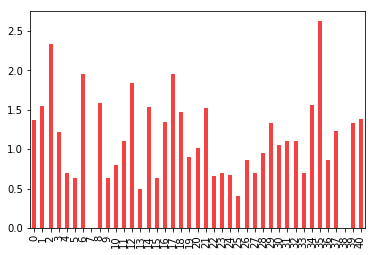

[Text(0, 0.5, 'Number of Distinct Atrists or Genres'),
 Text(0.5, 0, 'Spectral Community')]

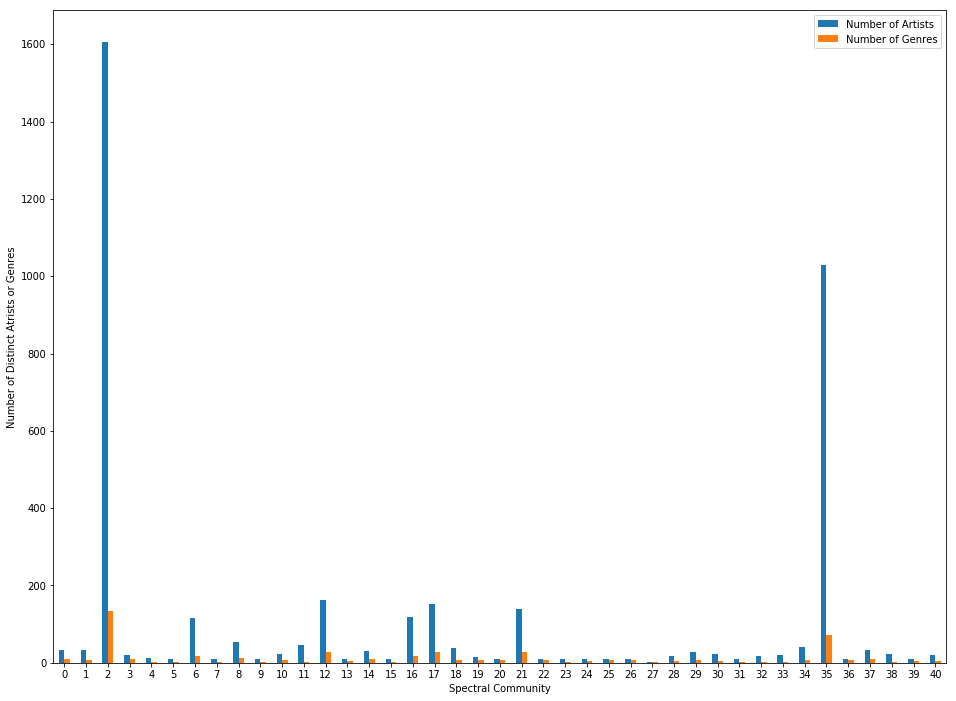

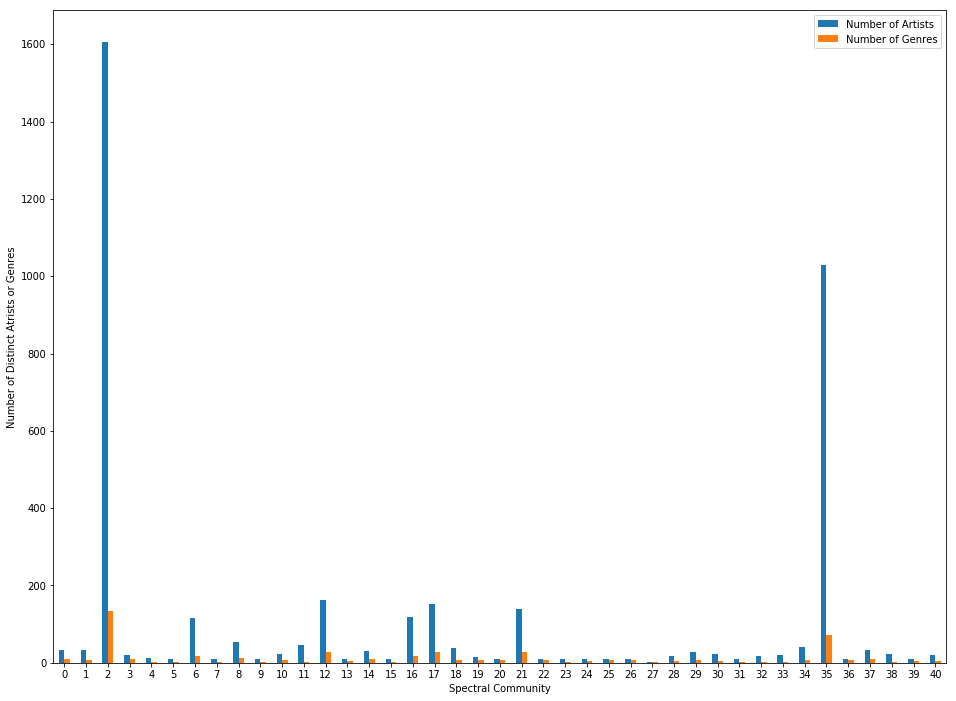

In [101]:
grouped_spectral = node_data.groupby(['Spectral Community', 'Genre']).size()



spectral_community_entropies = pd.Series([compute_entropy(cmty) for idx, cmty in grouped_spectral.groupby(level=0)])
# print(community_entropies)
# string.ascii_lowercase()
spectral_community_entropies.plot(kind='bar', color='#f44242', use_index=True)
plt.show()
# mu = community_entropies.mean()
# sigma = community_entropies.std()
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# plt.plot(x,mlab.normpdf(x, mu, sigma))
# plt.show()
num_genres = [cmty.count() for idx, cmty in grouped_spectral.groupby(level=0)]
num_artists = pd.Series([cmty.sum() for idx, cmty in grouped_spectral.groupby(level=0)])
plot_data = pd.DataFrame(data={'Number of Artists': num_artists, 'Number of Genres': num_genres})
ax = plot_data.plot.bar(rot=0, figsize=(16,12))
ax.set(xlabel='Spectral Community', ylabel='Number of Distinct Atrists or Genres')
# plot_data = plot_data.drop(index=[8,39])
ax = plot_data.plot.bar(rot=0, figsize=(16,12))
ax.set(xlabel='Spectral Community', ylabel='Number of Distinct Atrists or Genres')

In [104]:
grouped_betweenness.ix[2].sort_values(ascending=False)

Genre
classic rock           98
rock                   27
Progressive rock       21
pop                    19
singer-songwriter      16
new wave               16
80s                    14
folk                   13
60s                    12
blues                   9
glam rock               8
female vocalists        8
post-punk               7
hard rock               6
indie                   5
Psychedelic Rock        5
soul                    5
blues rock              5
Southern Rock           4
country                 3
electronic              3
folk rock               3
punk                    3
soft rock               3
rnb                     2
experimental            2
seen live               2
psychedelic             2
Hip-Hop                 2
latin                   2
heavy metal             2
jazz                    2
Fleetwood Mac           1
Garage Rock             1
Disco                   1
acid jazz               1
House                   1
Lo-Fi                   1
Melodi